In [1]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[2]") \
    .appName("Load Data From HDFS") \
    .getOrCreate()

In [2]:
spark

In [3]:
# load hadoop format file parquet from hdfs

#df = spark.read.parquet("hdfs://localhost:9820/proyek/bank-additional.parq")
bank_df = spark.read.parquet("bank-additional.parq")
bank_df.show(5)
bank_df.printSchema()

+---+---------+-------+-----------+-------+----+---------+-----+-----------+--------+--------+--------+-----------+---+
|age|      job|marital|  education|housing|loan|  contact|month|day_of_week|duration|campaign|previous|   poutcome|  y|
+---+---------+-------+-----------+-------+----+---------+-----+-----------+--------+--------+--------+-----------+---+
| 56|housemaid|married|   basic.4y|     no|  no|telephone|  may|        mon|     261|       1|       0|nonexistent| no|
| 57| services|married|high.school|     no|  no|telephone|  may|        mon|     149|       1|       0|nonexistent| no|
| 37| services|married|high.school|    yes|  no|telephone|  may|        mon|     226|       1|       0|nonexistent| no|
| 40|   admin.|married|   basic.6y|     no|  no|telephone|  may|        mon|     151|       1|       0|nonexistent| no|
| 56| services|married|high.school|     no| yes|telephone|  may|        mon|     307|       1|       0|nonexistent| no|
+---+---------+-------+-----------+-----

### Importing needful libraries

In [4]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.functions import mean, col, split, col, regexp_extract, when, lit
from pyspark.ml.feature import StringIndexer, IndexToString, VectorAssembler, VectorIndexer
from pyspark.ml.feature import QuantileDiscretizer, OneHotEncoder

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [5]:
# Number of customers in the dataframe
clients_count = bank_df.count()
print("Number of customers is {}".format(clients_count))

Number of customers is 41166


In [6]:
# Number of customers which are subscribed vs. those not subscribed a term deposit
groupBy_clients = bank_df.groupBy("y").count()
groupBy_clients.show()

+---+-----+
|  y|count|
+---+-----+
| no|36526|
|yes| 4640|
+---+-----+



In [7]:
bank_df.describe([t[0] for t in bank_df.dtypes if t[1] == 'int']).show()

+-------+------------------+-----------------+-----------------+-------------------+
|summary|               age|         duration|         campaign|           previous|
+-------+------------------+-----------------+-----------------+-------------------+
|  count|             41166|            41166|            41166|              41166|
|   mean| 40.02356313462566|258.3929456347471| 2.54875382597289|0.17305543409609872|
| stddev|10.421897109457703|259.3029641183626|2.645304359228272|0.49501715074689073|
|    min|                17|                0|                1|                  0|
|    max|                98|             4918|               32|                  7|
+-------+------------------+-----------------+-----------------+-------------------+



### Preparing Data for Machine Learning

In [8]:
def get_dummy(df, categoricalCols, continuousCols, labelCol):
    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in categoricalCols]
    encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol="{0}_encoded".format(indexer.getOutputCol())) for indexer in indexers]
    
    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders] + continuousCols, outputCol="features")
    indexer = StringIndexer(inputCol=labelCol, outputCol='indexedLabel')
    
    pipeline = Pipeline(stages = indexers + encoders + [assembler] + [indexer])
    model=pipeline.fit(df)
    data = model.transform(df)
    
    data = data.withColumn('label', col(labelCol))
    
    return data.select('features', 'indexedLabel', 'label'), StringIndexer(inputCol='label').fit(data)

In [9]:
# transform the data
categoricalColumns = ['job', 'marital', 'education', 'housing', 'loan', 'month', 'day_of_week', 'poutcome']
numericCols = ['age', 'duration', 'campaign', 'previous']
(bank_df, labelindexer) = get_dummy(bank_df, categoricalColumns, numericCols, 'y')
bank_df.show(5)

+--------------------+------------+-----+
|            features|indexedLabel|label|
+--------------------+------------+-----+
|(42,[8,11,18,22,2...|         0.0|   no|
|(42,[3,11,15,22,2...|         0.0|   no|
|(42,[3,11,15,21,2...|         0.0|   no|
|(42,[0,11,19,22,2...|         0.0|   no|
|(42,[3,11,15,23,3...|         0.0|   no|
+--------------------+------------+-----+
only showing top 5 rows



In [10]:
# fit the following featureIndexer model on the whole of the bank_df dataframe
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(bank_df)

featureIndexer.transform(bank_df).show(5)

+--------------------+------------+-----+--------------------+
|            features|indexedLabel|label|     indexedFeatures|
+--------------------+------------+-----+--------------------+
|(42,[8,11,18,22,2...|         0.0|   no|(42,[8,11,18,22,2...|
|(42,[3,11,15,22,2...|         0.0|   no|(42,[3,11,15,22,2...|
|(42,[3,11,15,21,2...|         0.0|   no|(42,[3,11,15,21,2...|
|(42,[0,11,19,22,2...|         0.0|   no|(42,[0,11,19,22,2...|
|(42,[3,11,15,23,3...|         0.0|   no|(42,[3,11,15,23,3...|
+--------------------+------------+-----+--------------------+
only showing top 5 rows



In [11]:
bank_df.show(5, False)

+---------------------------------------------------------------------------------------+------------+-----+
|features                                                                               |indexedLabel|label|
+---------------------------------------------------------------------------------------+------------+-----+
|(42,[8,11,18,22,23,33,36,38,39,40],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,56.0,261.0,1.0])       |0.0         |no   |
|(42,[3,11,15,22,23,33,36,38,39,40],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,57.0,149.0,1.0])       |0.0         |no   |
|(42,[3,11,15,21,22,23,33,36,38,39,40],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,37.0,226.0,1.0])|0.0         |no   |
|(42,[0,11,19,22,23,33,36,38,39,40],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,40.0,151.0,1.0])       |0.0         |no   |
|(42,[3,11,15,23,33,36,38,39,40],[1.0,1.0,1.0,1.0,1.0,1.0,56.0,307.0,1.0])              |0.0         |no   |
+---------------------------------------------------------------------------------------+------------+-----+
only showing top 5 

### Data Splitting

In [12]:
(trainingData, testData) = bank_df.randomSplit([0.7, 0.3], seed=10)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 28721
Test Dataset Count: 12445


In [13]:
print("The first 5 samples of the Training Dataset:")
trainingData.show(5, False)
print("The first 5 samples of the Test Dataset:")
testData.show(5, False)

The first 5 samples of the Training Dataset:
+---------------------------------------------------------------------------------------+------------+-----+
|features                                                                               |indexedLabel|label|
+---------------------------------------------------------------------------------------+------------+-----+
|(42,[0,11,14,21,22,23,32,36,38,39,40],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,25.0,251.0,4.0])|0.0         |no   |
|(42,[0,11,14,21,22,23,32,36,38,39,40],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,29.0,302.0,1.0])|0.0         |no   |
|(42,[0,11,14,21,22,23,32,36,38,39,40],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,30.0,911.0,2.0])|1.0         |yes  |
|(42,[0,11,14,21,22,23,32,36,38,39,40],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,31.0,102.0,4.0])|0.0         |no   |
|(42,[0,11,14,21,22,23,32,36,38,39,40],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,32.0,151.0,5.0])|0.0         |no   |
+----------------------------------------------------------------------------------

# Fit and Evaluate Models

### Logistic Regression

In [14]:
#lr = LogisticRegression(labelCol="indexedLabel", featuresCol="indexedFeatures") # using this line if you would using indexedFeatures instead features column
lr = LogisticRegression(labelCol="indexedLabel", featuresCol="features")

### Pipeline Architecture

In [15]:
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelindexer.labels) 

pipeline = Pipeline(stages=[featureIndexer, lr, labelConverter])

lrModel = pipeline.fit(trainingData)

### Predictions

In [16]:
# Make predictions on the test data using the transform() method.
predictions = lrModel.transform(testData)
predictions.show(5)

+--------------------+------------+-----+--------------------+--------------------+--------------------+----------+--------------+
|            features|indexedLabel|label|     indexedFeatures|       rawPrediction|         probability|prediction|predictedLabel|
+--------------------+------------+-----+--------------------+--------------------+--------------------+----------+--------------+
|(42,[0,11,14,21,2...|         0.0|   no|(42,[0,11,14,21,2...|[3.35675443389378...|[0.96632532344417...|       0.0|            no|
|(42,[0,11,14,21,2...|         0.0|   no|(42,[0,11,14,21,2...|[3.47213268200217...|[0.96988437379362...|       0.0|            no|
|(42,[0,11,14,21,2...|         0.0|   no|(42,[0,11,14,21,2...|[2.77675761428123...|[0.94140685024800...|       0.0|            no|
|(42,[0,11,14,21,2...|         0.0|   no|(42,[0,11,14,21,2...|[3.90803421628000...|[0.98031533176156...|       0.0|            no|
|(42,[0,11,14,21,2...|         0.0|   no|(42,[0,11,14,21,2...|[3.99371317113042...|

In [17]:
predictions.select("features", "label", "probability", "predictedLabel").show(5)

+--------------------+-----+--------------------+--------------+
|            features|label|         probability|predictedLabel|
+--------------------+-----+--------------------+--------------+
|(42,[0,11,14,21,2...|   no|[0.96632532344417...|            no|
|(42,[0,11,14,21,2...|   no|[0.96988437379362...|            no|
|(42,[0,11,14,21,2...|   no|[0.94140685024800...|            no|
|(42,[0,11,14,21,2...|   no|[0.98031533176156...|            no|
|(42,[0,11,14,21,2...|   no|[0.98190241047567...|            no|
+--------------------+-----+--------------------+--------------+
only showing top 5 rows



In [33]:
predictions.select("features").show(5)

+--------------------+
|            features|
+--------------------+
|(42,[0,11,14,21,2...|
|(42,[0,11,14,21,2...|
|(42,[0,11,14,21,2...|
|(42,[0,11,14,21,2...|
|(42,[0,11,14,21,2...|
+--------------------+
only showing top 5 rows



### Compute the model accuracy

In [18]:
cm = predictions.select("label", "predictedLabel")          
cm.groupby('label').agg({'label': 'count'}).show()  
cm.groupby('predictedLabel').agg({'predictedLabel': 'count'}).show()

+-----+------------+
|label|count(label)|
+-----+------------+
|   no|       11049|
|  yes|        1396|
+-----+------------+

+--------------+---------------------+
|predictedLabel|count(predictedLabel)|
+--------------+---------------------+
|            no|                11713|
|           yes|                  732|
+--------------+---------------------+



In [19]:
predictions.groupBy('label', 'predictedLabel').count().show()

+-----+--------------+-----+
|label|predictedLabel|count|
+-----+--------------+-----+
|   no|            no|10780|
|   no|           yes|  269|
|  yes|           yes|  463|
|  yes|            no|  933|
+-----+--------------+-----+



In [20]:
print("The Accuracy for test set is {}".format(cm.filter(cm.label == cm.predictedLabel).count()/cm.count()))

The Accuracy for test set is 0.9034150261149055


In [21]:
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
print("The Accuracy for test set is {}".format(evaluator.evaluate(predictions)))

The Accuracy for test set is 0.9034150261149055


# Tuning Model with ParamGridBuilder and CrossValidator

## Hyperparameter tuning using 5-fold cross validation

### Create ParamGrid for Cross Validation

In [22]:
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="indexedLabel")

### Create and run 5-fold Cross Validator

In [23]:
pipeline = Pipeline(stages=[featureIndexer, lr, labelConverter]) 
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5, parallelism=10, seed=100)
cvModel = cv.fit(trainingData)

In [24]:
predictions = cvModel.transform(testData)

predictions.select("features", "label", "probability", "predictedLabel").show(5)

+--------------------+-----+--------------------+--------------+
|            features|label|         probability|predictedLabel|
+--------------------+-----+--------------------+--------------+
|(42,[0,11,14,21,2...|   no|[0.92262365196450...|            no|
|(42,[0,11,14,21,2...|   no|[0.92641703529117...|            no|
|(42,[0,11,14,21,2...|   no|[0.89200993388020...|            no|
|(42,[0,11,14,21,2...|   no|[0.94269523325370...|            no|
|(42,[0,11,14,21,2...|   no|[0.94480545886916...|            no|
+--------------------+-----+--------------------+--------------+
only showing top 5 rows



### Evaluate the best model

In [25]:
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
print("The Accuracy for test set is {}".format(evaluator.evaluate(predictions)))

The Accuracy for test set is 0.8875050220972278


In [26]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics

predictionAndLabel = predictions.select("prediction", "indexedLabel").rdd

# Instantiate metrics object 
metricsMulti = MulticlassMetrics(predictionAndLabel)
metricsBinary= BinaryClassificationMetrics(predictionAndLabel)
# Overall statistics 
confusionMatrix = metricsMulti.confusionMatrix()
precision = metricsMulti.precision(label=1) 
recall = metricsMulti.recall(label=1) 

print("Summary Stats")
print("Confusion Matrix = \n %s" % confusionMatrix)
print("Precision = %s" % precision) 
print("Recall = %s" % recall)  

# Area under precision-recall curve 
print("Area under PR = %s" % metricsBinary.areaUnderPR) 
# Area under ROC curve 
print("Area under ROC = %s" % metricsBinary.areaUnderROC)

Summary Stats
Confusion Matrix = 
 DenseMatrix([[10529.,   520.],
             [  880.,   516.]])
Precision = 0.4980694980694981
Recall = 0.36962750716332377
Area under PR = 0.3764404070012357
Area under ROC = 0.6612822122657056


In [27]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="indexedLabel")
print("The area under ROC for test set is {}".format(evaluator.evaluate(predictions)))

The area under ROC for test set is 0.6612822122657056


### Plot Confusion Matrix

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [29]:
class_temp = predictions.select("label").groupBy("label").count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
print(class_temp)

['no', 'yes']


In [30]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_temp)
cnf_matrix


array([[10529,   520],
       [  880,   516]], dtype=int64)

Confusion matrix, without normalization
[[10529   520]
 [  880   516]]


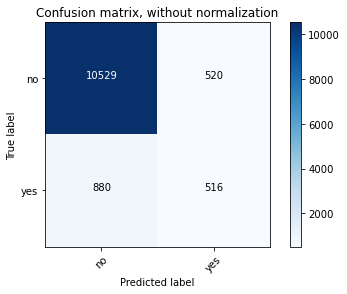

In [31]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp, title='Confusion matrix, without normalization')
plt.show()


Normalized confusion matrix
[[0.95293692 0.04706308]
 [0.63037249 0.36962751]]


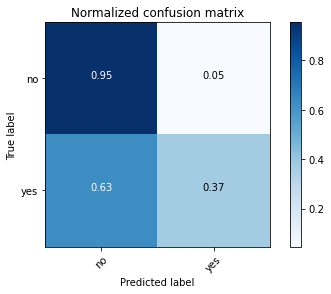

In [32]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp, normalize=True, title='Normalized confusion matrix')
plt.show()